# GOAL
Using xHMM to find CNV in chromosome 5 of sWGA field isolates.

In [1]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm
%matplotlib inline

In [2]:
PF_FIELD_GDNA_COV_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output"
xHMM_OUT_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.chr5.xcnv.win300.tsv"
SAMPLE_MAP_CSV = "/Volumes/nfs/users/nfs_t/tn6/gitrepo/pf_swga_cnv/data/sWGA_plexing_sample_map.csv"
PYSAM_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv_wgs/output/pysamstats_gc"
GAUSSIAN_HMM_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv_wgs/output/gaussian_hmm_cnv"

In [3]:
xHMM_PC_LOADINGS_STD_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.RD_PCA.PC_SD.txt"
xHMM_RD_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.same_filtered.RD.chr5.txt"

## xHMM Principal Components of the sWGA samples

In [4]:
loadings_std = pandas.read_csv(xHMM_PC_LOADINGS_STD_TSV, delimiter="\t")
# loadings = loadings.transpose()
# loadings = loadings.set_index("U_T")
# loadings = loadings.transpose()
display(loadings_std.head())
display(loadings_std.shape)
display(loadings_std.describe())
# loadings = loadings.astype(float)

,D,SD
0,PC1,61238.151723
1,PC2,54492.375506
2,PC3,31646.061986
3,PC4,22800.477153
4,PC5,18780.689605


(37, 2)

,SD
count,37.000000
mean,11198.623079
std,12930.503481
min,0.000005
25%,4634.808713
50%,6327.329122
75%,12396.042280
max,61238.151723


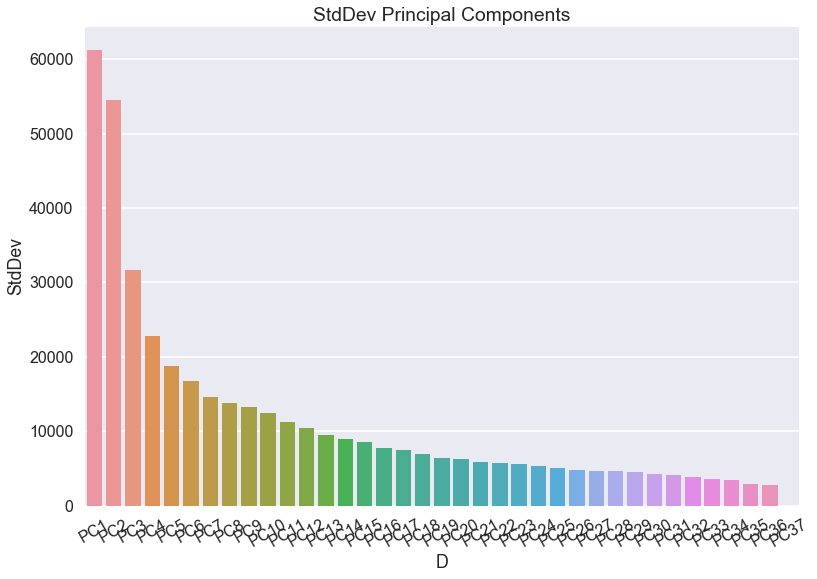

In [5]:
sns.set_context("poster")
ax = sns.barplot(x="D", y="SD", data=loadings_std)
sns.plt.title("StdDev Principal Components")
ax.set_ylabel("StdDev")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

## xHMM Copy Number Calls

In [6]:
xhmm_out = pandas.read_csv(xHMM_OUT_TSV, sep="\t")
display(xhmm_out.shape)
display(xhmm_out.head())
display(xhmm_out.describe())

(3602, 3)

,sample,window,copy_number
0,PF1155-CW,209400,2
1,PF1155-CW,209700,2
2,PF1155-CW,210000,2
3,PF1155-CW,210300,2
4,PF1155-CW,210600,2


,window,copy_number
count,3.602000e+03,3602.000000
mean,6.661622e+05,1.170461
std,3.996745e+05,0.985501
min,2.700000e+04,0.000000
25%,2.166000e+05,0.000000
50%,7.020000e+05,2.000000
75%,1.036725e+06,2.000000
max,1.333500e+06,2.000000


In [7]:
# Map the sample names from WGS run, sWGA run
sample_map = pandas.read_csv(SAMPLE_MAP_CSV, sep=",")
display(sample_map.shape)
display(sample_map.head())

(88, 8)

,oxford_code_swga_X10,oxford_code_swga_HiSeq2000,oxford_code_wgs_Hiseq2000,seqscape_name_swga_X10,seqscape_name_swga_HiSeq2000,seqscape_name_wgs_Hiseq2000,parasitemia,experiment_swga_X10
0,PF1170-CW,PF1170-C,PF1170-Cx,3429STDY6404057,3910STDY6216486,3909STDY6204234,4.803000,12_16h
1,PF1141-CW,PF1141-C,PF1141-Cx,3429STDY6404058,3910STDY6216476,3909STDY6204224,1.373500,12_16h
2,PF1195-CW,PF1195-C,PF1195-Cx,3429STDY6404059,3910STDY6216504,3909STDY6204252,0.165000,12_16h
3,PF1188-CW,PF1188-C,PF1188-Cx,3429STDY6404060,3910STDY6216500,3909STDY6204248,2.849000,12_16h
4,PF1061-CxW,PF1061-Cx,PF1061-C,3429STDY6404061,CR43,3061STDY5801218,0.883725,12_16h


In [8]:
xhmm_out_map = xhmm_out.set_index("sample").join(
    sample_map[["oxford_code_swga_X10", "seqscape_name_wgs_Hiseq2000"]].set_index("oxford_code_swga_X10"))
xhmm_out_map.index.name = "sample"
display(xhmm_out_map.head())
display(xhmm_out_map.describe())

,window,copy_number,seqscape_name_wgs_Hiseq2000
sample,,,
PF1010-CxW,209700,2,3061STDY5801190
PF1010-CxW,210000,2,3061STDY5801190
PF1010-CxW,210300,2,3061STDY5801190
PF1010-CxW,210600,2,3061STDY5801190
PF1010-CxW,210900,2,3061STDY5801190


,window,copy_number
count,3.602000e+03,3602.000000
mean,6.661622e+05,1.170461
std,3.996745e+05,0.985501
min,2.700000e+04,0.000000
25%,2.166000e+05,0.000000
50%,7.020000e+05,2.000000
75%,1.036725e+06,2.000000
max,1.333500e+06,2.000000


In [9]:
def get_hmm_cnv_calls(calls_dir):
    sample_stats_list = []
    # Expect <sample>.<library>.<lane>.cnv.tsv
    for i, cnv_call_tsv in enumerate(glob.glob(calls_dir + os.sep + "*cnv.tsv")):
        
        sample_stats = pandas.read_csv(cnv_call_tsv, sep="\t", 
                                  comment="#", skip_blank_lines=True)
        
        sample, library, lane = os.path.basename(cnv_call_tsv).split(".")[:3]
        sample_stats["sample"] = sample
        sample_stats["library"] = library
        sample_stats["lane"] = lane
        if not lane.startswith("20295_4"):
            continue
#         display(sample_stats)
        
#         if i > 2:
#             break
            
        sample_stats_list.append(sample_stats)


    all_samples_metrics = pandas.concat(sample_stats_list)
    return all_samples_metrics

In [10]:
# Get the field isolate copy number calls from Gaussian HMM on GC normalized coverage
cnv_calls = get_hmm_cnv_calls(GAUSSIAN_HMM_DIR)
display(cnv_calls.shape)
display(cnv_calls.head())
display(cnv_calls.tail())
display(cnv_calls.describe())

(157058, 12)

,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,sample,window
0,0,20.0,26.397351,26.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,PF1092-CxW,900.0
1,0,30.0,31.765182,32.0,20295_4_36,16880631,0.033027,44.743370,1.477733,1.0,PF1092-CxW,1200.0
2,0,30.0,32.420455,32.0,20295_4_36,16880631,0.022350,44.743370,1.000000,1.0,PF1092-CxW,1500.0
3,0,20.0,27.816176,28.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,PF1092-CxW,1800.0
4,0,20.0,27.446809,27.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,PF1092-CxW,2100.0


,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,sample,window
4391,0,20.0,27.391892,27.0,20295_4_8,16880558,0.016930,89.398420,1.513514,2.0,PF1134-CW,1341600.0
4392,0,20.0,27.536667,28.0,20295_4_8,16880558,0.029419,89.398420,2.630000,3.0,PF1134-CW,1341900.0
4393,0,20.0,29.456667,30.0,20295_4_8,16880558,0.031954,89.398420,2.856667,3.0,PF1134-CW,1342200.0
4394,0,20.0,29.757692,30.0,20295_4_8,16880558,0.019188,89.398420,1.715385,2.0,PF1134-CW,1342500.0
4395,0,30.0,31.029412,31.0,20295_4_8,16880558,0.030807,32.459949,1.000000,1.0,PF1134-CW,1342800.0


,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,window
count,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,1.570580e+05
mean,1.194858,14.177692,18.994795,18.990287,0.989463,87.719001,87.138794,86.956280,6.804317e+05
std,0.781000,6.387250,5.818773,5.941164,1.737245,25.542959,152.134632,151.114574,3.789764e+05
min,0.000000,0.000000,1.000000,1.000000,0.007145,1.000000,1.000000,1.000000,9.000000e+02
25%,1.000000,10.000000,14.646667,15.000000,0.292431,78.433042,23.440000,23.000000,3.525000e+05
50%,1.000000,10.000000,18.803333,19.000000,0.584780,91.308496,50.581667,50.000000,6.804000e+05
75%,1.000000,20.000000,22.556667,23.000000,1.104897,104.066157,99.290000,99.000000,1.007700e+06
max,4.000000,50.000000,52.166667,52.000000,102.605036,139.959508,7916.820000,7942.000000,1.342800e+06


In [11]:
both = cnv_calls.set_index(["sample", "window"]).join(
    xhmm_out.reset_index().set_index(["sample", "window"]), 
                                                     rsuffix=".xhmm")
both.loc[pandas.isnull(both["copy_number.xhmm"]), "copy_number.xhmm"] = 1


both = both.reset_index()
display(both.describe())
display(both.head())

,window,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm
count,1.570580e+05,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,3570.000000,157058.000000
mean,6.804317e+05,1.194858,14.177692,18.994795,18.990287,0.989463,87.719001,87.138794,86.956280,1802.456863,1.004113
std,3.789764e+05,0.781000,6.387250,5.818773,5.941164,1.737245,25.542959,152.134632,151.114574,1042.031887,0.150711
min,9.000000e+02,0.000000,0.000000,1.000000,1.000000,0.007145,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.525000e+05,1.000000,10.000000,14.646667,15.000000,0.292431,78.433042,23.440000,23.000000,895.250000,1.000000
50%,6.804000e+05,1.000000,10.000000,18.803333,19.000000,0.584780,91.308496,50.581667,50.000000,1809.500000,1.000000
75%,1.007700e+06,1.000000,20.000000,22.556667,23.000000,1.104897,104.066157,99.290000,99.000000,2704.750000,1.000000
max,1.342800e+06,4.000000,50.000000,52.166667,52.000000,102.605036,139.959508,7916.820000,7942.000000,3601.000000,2.000000


,sample,window,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm
0,PF1092-CxW,900.0,0,20.0,26.397351,26.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,NaN,1.0
1,PF1092-CxW,1200.0,0,30.0,31.765182,32.0,20295_4_36,16880631,0.033027,44.743370,1.477733,1.0,NaN,1.0
2,PF1092-CxW,1500.0,0,30.0,32.420455,32.0,20295_4_36,16880631,0.022350,44.743370,1.000000,1.0,NaN,1.0
3,PF1092-CxW,1800.0,0,20.0,27.816176,28.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,NaN,1.0
4,PF1092-CxW,2100.0,0,20.0,27.446809,27.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,NaN,1.0


In [12]:
bothmap = both.set_index("sample").join(
    sample_map[["oxford_code_swga_X10", "seqscape_name_wgs_Hiseq2000"]].set_index("oxford_code_swga_X10"))
bothmap.index.name = "sample"
bothmap = bothmap.reset_index()
display(bothmap.shape)
display(bothmap.head())
display(bothmap.describe())

(157058, 15)

,sample,window,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm,seqscape_name_wgs_Hiseq2000
0,PF1010-CxW,8100.0,0,30.0,30.563910,30.0,20295_4_33,16880628,0.039724,25.173615,1.000000,1.0,NaN,1.0,3061STDY5801190
1,PF1010-CxW,8400.0,0,30.0,30.944444,31.0,20295_4_33,16880628,0.039724,25.173615,1.000000,1.0,NaN,1.0,3061STDY5801190
2,PF1010-CxW,20400.0,0,10.0,10.662252,11.0,20295_4_33,16880628,0.012459,80.265737,1.000000,1.0,NaN,1.0,3061STDY5801190
3,PF1010-CxW,26100.0,1,20.0,27.137931,27.0,20295_4_33,16880628,0.239197,47.476874,11.356322,13.0,NaN,1.0,3061STDY5801190
4,PF1010-CxW,26400.0,1,0.0,8.210000,6.0,20295_4_33,16880628,0.607405,44.906872,27.276667,26.0,NaN,1.0,3061STDY5801190


,window,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm
count,1.570580e+05,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,3570.000000,157058.000000
mean,6.804317e+05,1.194858,14.177692,18.994795,18.990287,0.989463,87.719001,87.138794,86.956280,1802.456863,1.004113
std,3.789764e+05,0.781000,6.387250,5.818773,5.941164,1.737245,25.542959,152.134632,151.114574,1042.031887,0.150711
min,9.000000e+02,0.000000,0.000000,1.000000,1.000000,0.007145,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.525000e+05,1.000000,10.000000,14.646667,15.000000,0.292431,78.433042,23.440000,23.000000,895.250000,1.000000
50%,6.804000e+05,1.000000,10.000000,18.803333,19.000000,0.584780,91.308496,50.581667,50.000000,1809.500000,1.000000
75%,1.007700e+06,1.000000,20.000000,22.556667,23.000000,1.104897,104.066157,99.290000,99.000000,2704.750000,1.000000
max,1.342800e+06,4.000000,50.000000,52.166667,52.000000,102.605036,139.959508,7916.820000,7942.000000,3601.000000,2.000000


Total Samples

In [13]:
display(len(bothmap["sample"].unique()))

36

In [14]:
samples = bothmap["seqscape_name_wgs_Hiseq2000"].unique()
total_samples = len(samples)

In [15]:
samples

array(['3061STDY5801190', '3061STDY5801214', '3061STDY5801254',
       '3061STDY5801270', '3061STDY5801215', '3061STDY5801201',
       '3061STDY5801233', '3061STDY5801218', '3061STDY5801203',
       '3061STDY5801219', '3061STDY5801235', '3061STDY5801251',
       '3061STDY5801259', '3061STDY5801252', '3061STDY5801276',
       '3061STDY5801197', '3061STDY5801286', '3061STDY5801294',
       '3909STDY6204209', '3909STDY6204210', '3909STDY6204214',
       '3909STDY6204215', '3909STDY6204216', '3909STDY6204217',
       '3909STDY6204218', '3909STDY6204219', '3909STDY6204220',
       '3909STDY6204221', '3909STDY6204222', '3909STDY6204224',
       '3909STDY6204230', '3909STDY6204234', '3909STDY6204239',
       '3909STDY6204248', '3909STDY6204249', '3909STDY6204252'], dtype=object)

In [16]:
def plotter(total_cols, samples, sample_col, 
            df, y_label, x_label, x_col, y_col, sharey=False):
    total_samples = len(samples)
    total_rows =  int(np.ceil(total_samples // total_cols))
    fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=sharey, figsize=(15, 40))
    for row_idx, row in enumerate(axes):  
        for col_idx, ax in enumerate(row):
            sample_idx = (row_idx* total_cols) + col_idx
            if sample_idx >= len(samples):
                break  # No more plots, end of samples
            subset = df[(df[sample_col] == samples[sample_idx]) ].sort_values(x_col, ascending=True)
            ax.plot(subset[x_col], subset[y_col], color="orange")

            ax.set_title(samples[sample_idx])
            ax.set_ylabel(y_label)
            ax.set_xlabel(x_label)
    plt.tight_layout()
    plt.show()

**GaussianHMM vs xHMM Copy Number Calls for Each Sample**

Blue dot is is Gaussian HMM copy number call, Orange line is xHMM Copy Number Call

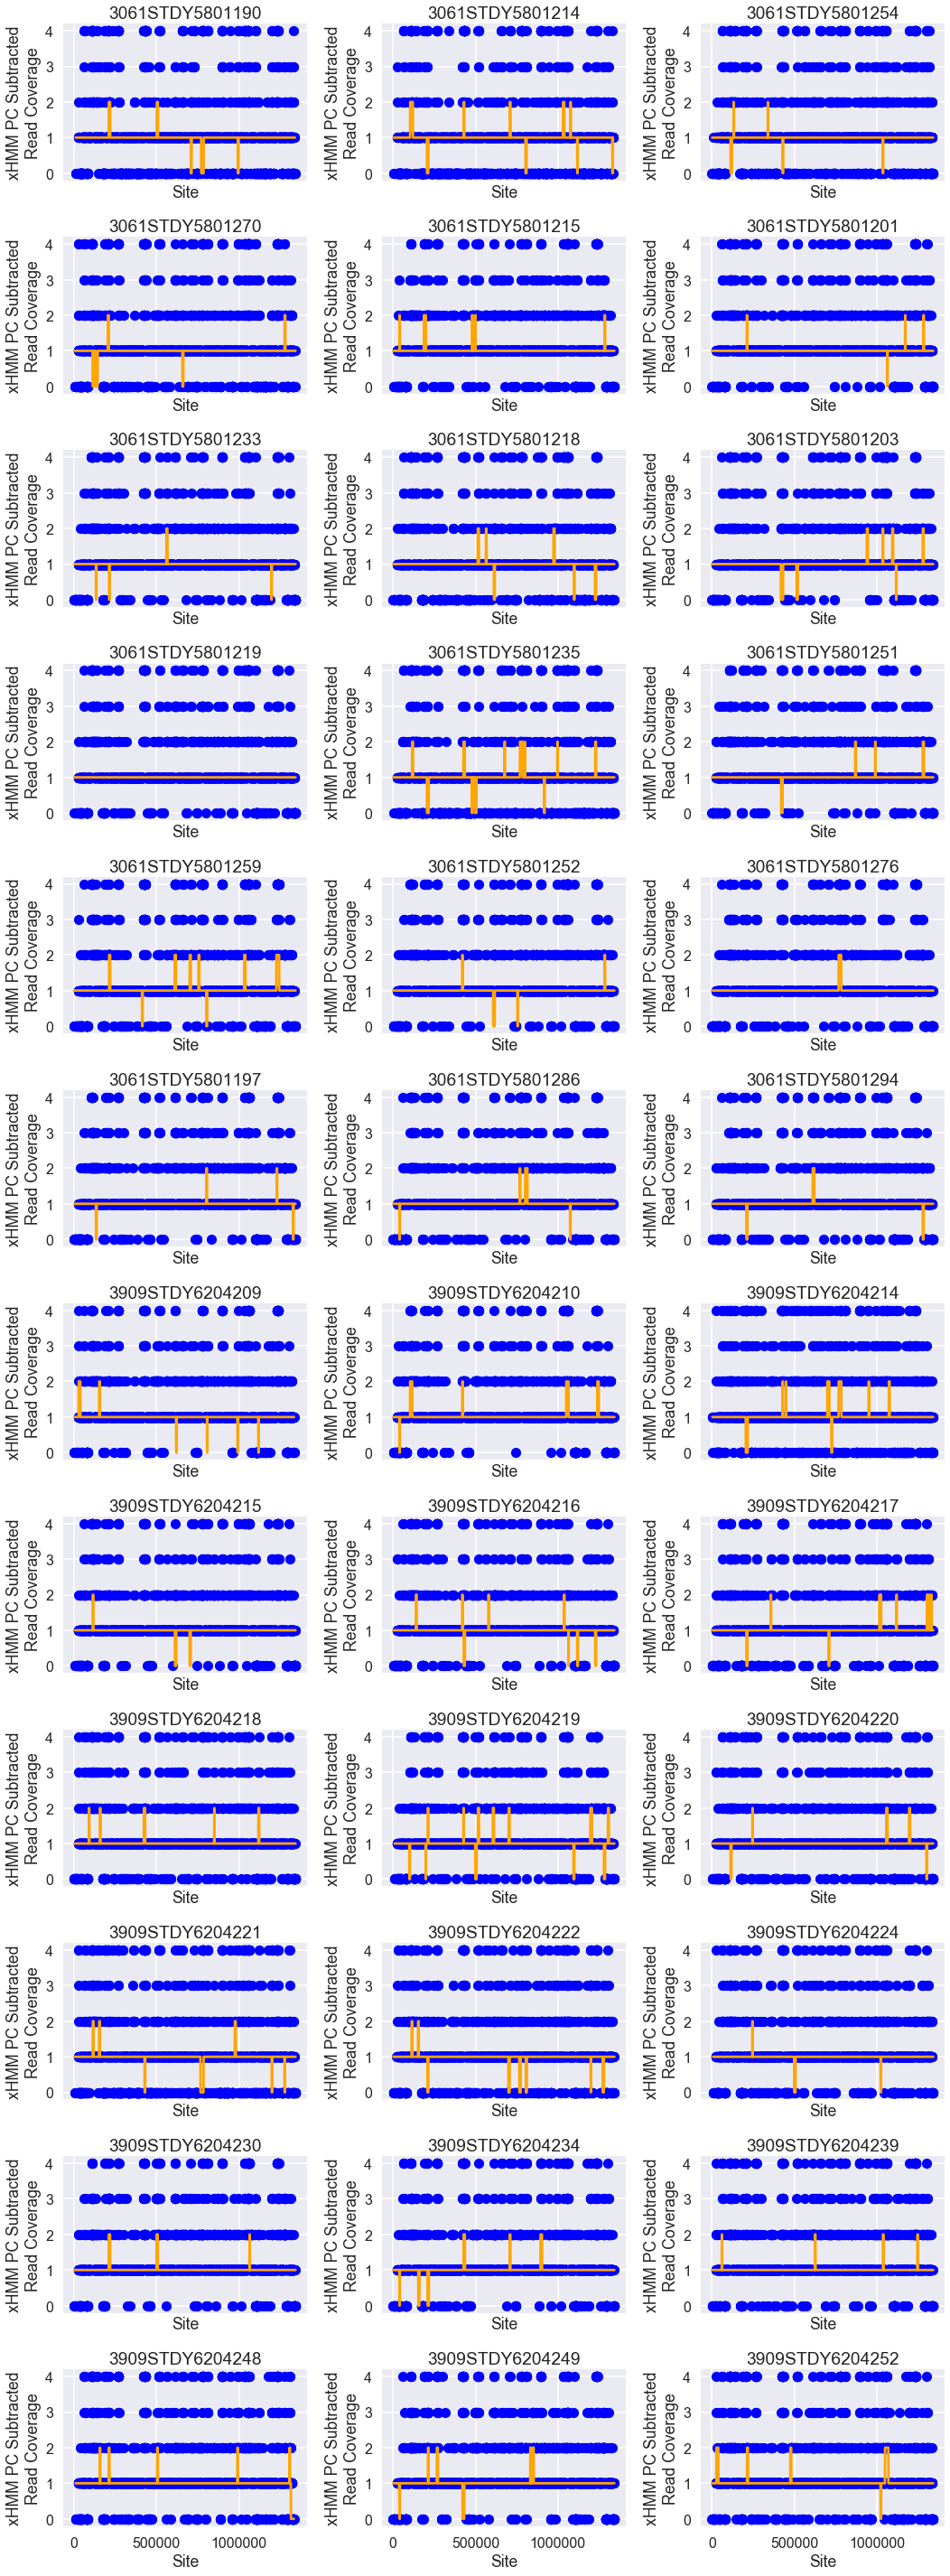

In [17]:
# row and column sharing
# Plot each sample copy number along genome
# plotter(total_cols=3, samples=samples, sample_col="seqscape_name_wgs_Hiseq2000", 
#         df=bothmap, y_label="Copy Number", x_label="Site", 
#         x_col="window", y_col="copy_number.xhmm", sharey=False)



total_cols = 3
total_rows =  int(np.ceil(total_samples // total_cols))
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = bothmap[(bothmap["seqscape_name_wgs_Hiseq2000"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ghmm_line = ax.plot(subset["window"], subset["copy_number"], "bo")
        xhmm_line = ax.plot(subset["window"], subset["copy_number.xhmm"], "orange")
        

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("xHMM PC Subtracted\nRead Coverage")
        ax.set_xlabel("Site")
# TODO:  FIX ME.  Legend code does not work. 
# fig.legend(handles=[xhmm_line, ghmm_line], 
#            labels=["xHMM", "Gaussian HMM"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()

# Normalized Coverage Along Genome
GC Normalized Read Coverage

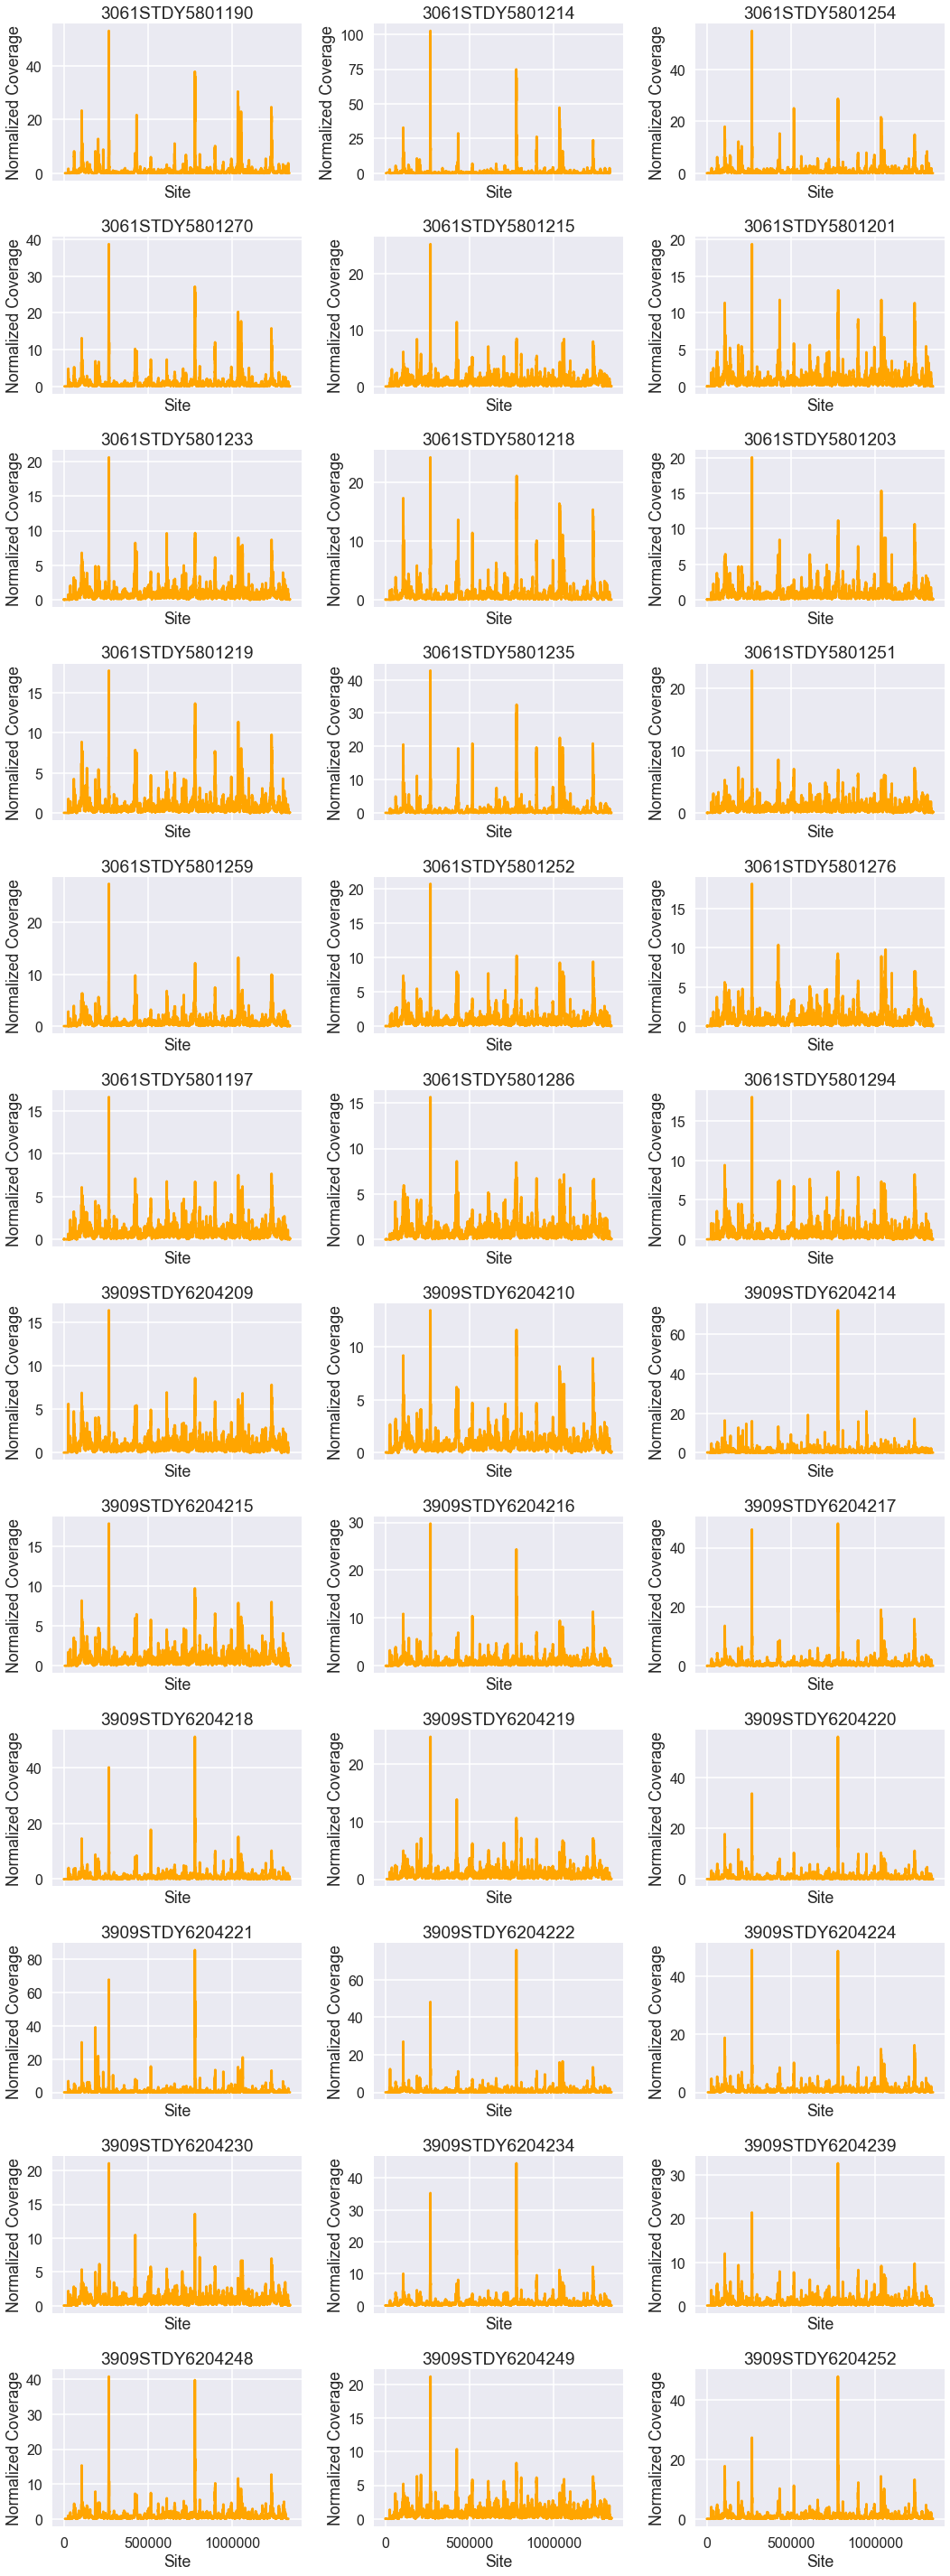

In [18]:
# Plot Normalized Coverage along genome
plotter(total_cols=3, samples=samples, sample_col="seqscape_name_wgs_Hiseq2000", 
        df=bothmap, y_label="Normalized Coverage", x_label="Site", 
        x_col="window", y_col="norm_reads_all", sharey=False)

# Raw Coverage Along Genome

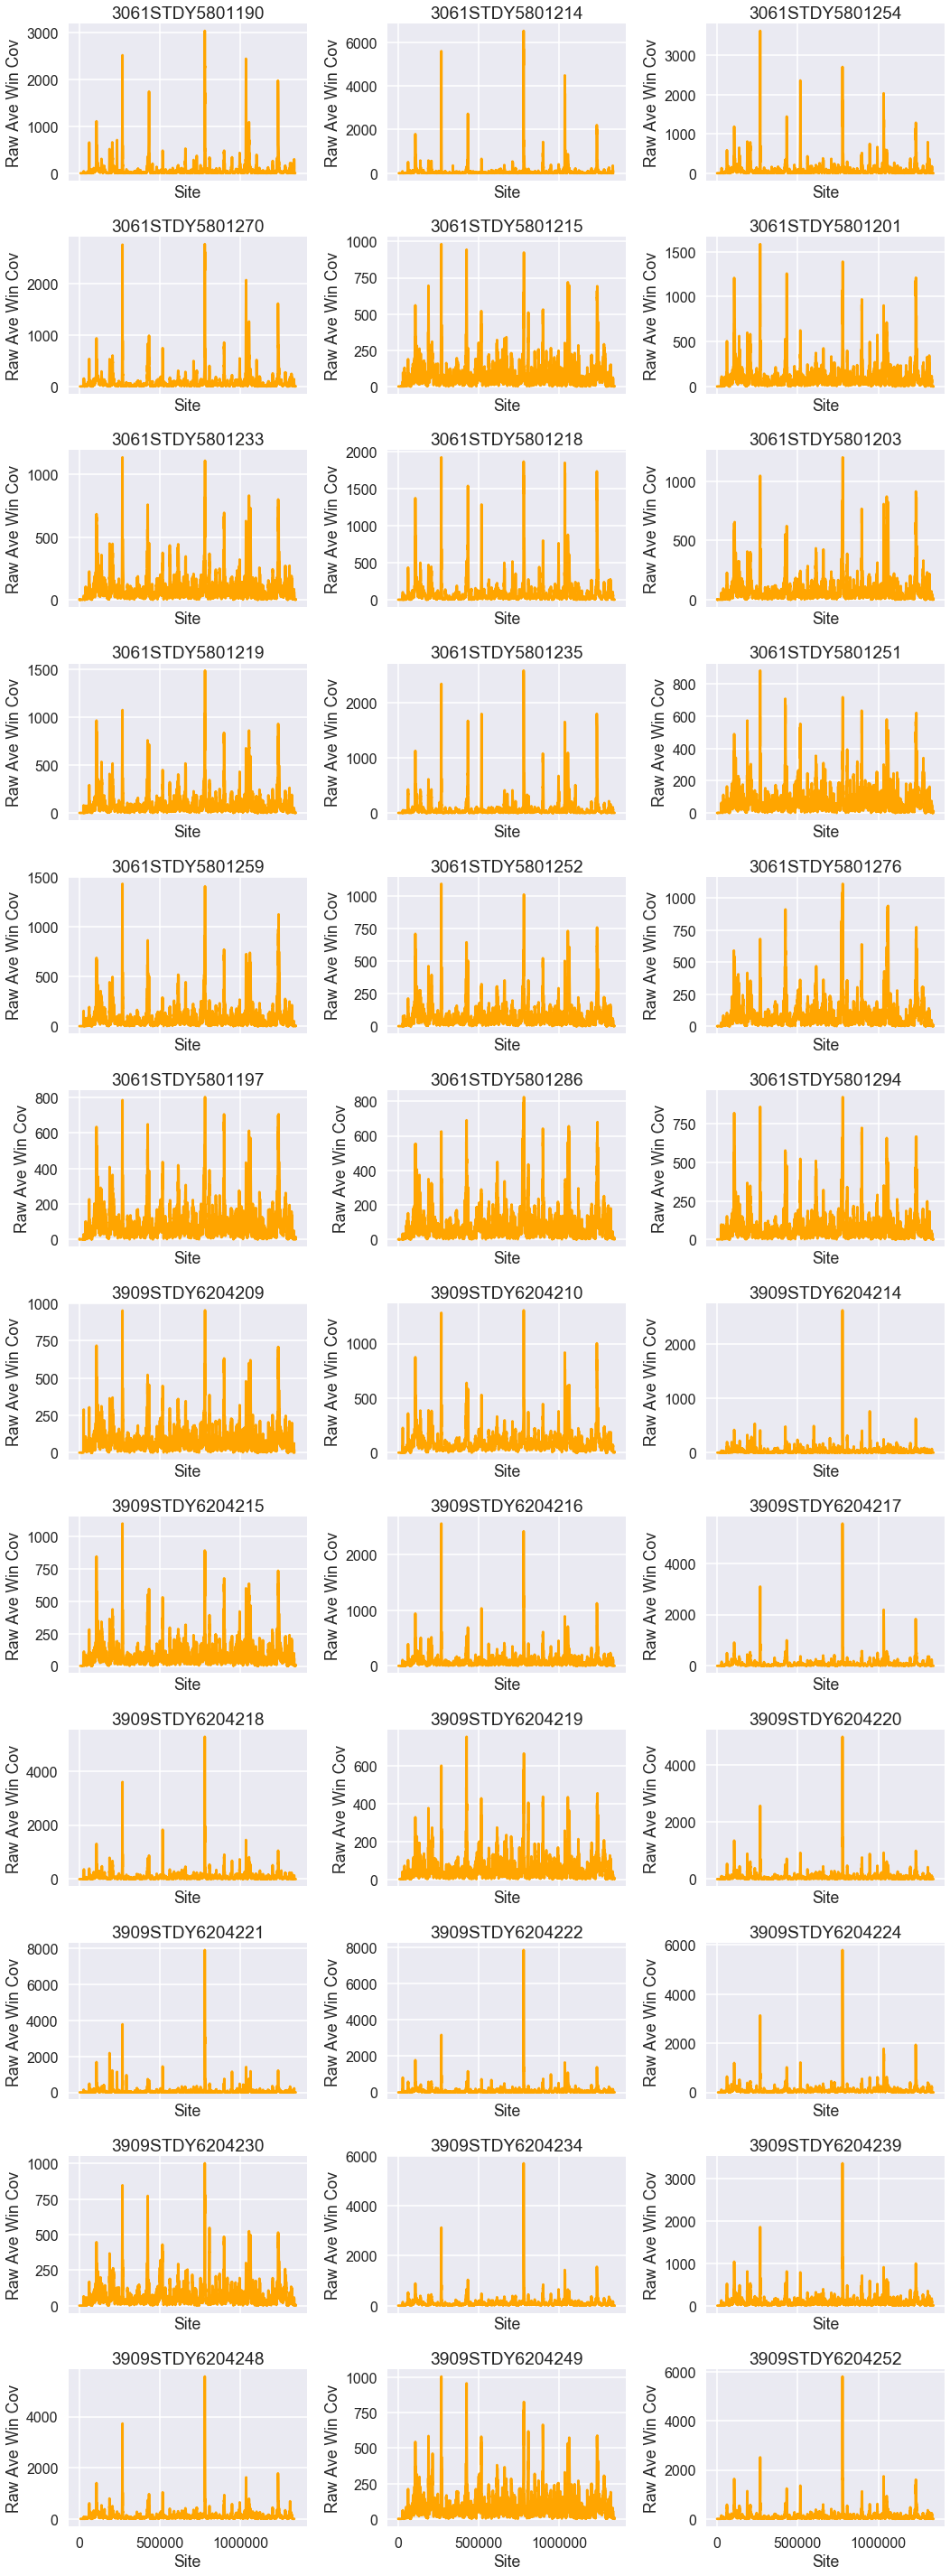

In [19]:
plotter(total_cols=3, samples=samples, sample_col="seqscape_name_wgs_Hiseq2000", 
        df=bothmap, y_label="Raw Ave Win Cov", x_label="Site", 
        x_col="window", y_col="reads_all_win_mean", sharey=False)

# Read Coverage After Subtract Top  Principal Components
By default, xHMM removes top prinicipal components that have variance >= 0.7/n, where n is the number of components.

In [20]:
# Get xHMM read coverage Normalized by removing top PC components
xhmm_rd = pandas.read_csv(xHMM_RD_TSV, sep="\t")
xhmm_rd.head()
xhmm_rd = xhmm_rd.set_index("Matrix")
xhmm_rd.index.name = "Matrix"
xhmm_rd = xhmm_rd.transpose()
xhmm_rd.head()
xhmm_rd = xhmm_rd.reset_index()
xhmm_rd = xhmm_rd.rename(columns={"index": "window"})
xhmm_rd["window"] = xhmm_rd["window"].str.replace("Pf3D7_05_v3:", "")
xhmm_rd["window"] = xhmm_rd["window"].str.split("-").str[0]
xhmm_rd["window"]  = xhmm_rd["window"].astype(np.int)
xhmm_rd["window"] = xhmm_rd["window"] - 1
xhmm_rd.head()

xhmm_rd = xhmm_rd.melt(id_vars="window", value_vars=xhmm_rd.columns.values[1:], var_name="sample", value_name="norm_cov")
xhmm_rd = xhmm_rd.set_index("sample").join(
    sample_map[["oxford_code_swga_X10", "seqscape_name_wgs_Hiseq2000"]].set_index("oxford_code_swga_X10"))
xhmm_rd.loc[pandas.isnull(xhmm_rd["seqscape_name_wgs_Hiseq2000"]), "seqscape_name_wgs_Hiseq2000"] = "3D7_10-T1"
display(xhmm_rd.shape)
display(xhmm_rd.head())
display(xhmm_rd.describe())

(132978, 3)

,window,norm_cov,seqscape_name_wgs_Hiseq2000
3D7_10-T1,27000,53.53,3D7_10-T1
3D7_10-T1,27300,48.87,3D7_10-T1
3D7_10-T1,28200,56.70,3D7_10-T1
3D7_10-T1,28500,34.48,3D7_10-T1
3D7_10-T1,30600,37.56,3D7_10-T1


,window,norm_cov
count,1.329780e+05,132978.000000
mean,6.774124e+05,66.542101
std,3.663394e+05,57.987077
min,2.700000e+04,0.000000
25%,3.633000e+05,25.862500
50%,6.703500e+05,50.120000
75%,9.816000e+05,89.947500
max,1.333500e+06,726.820000


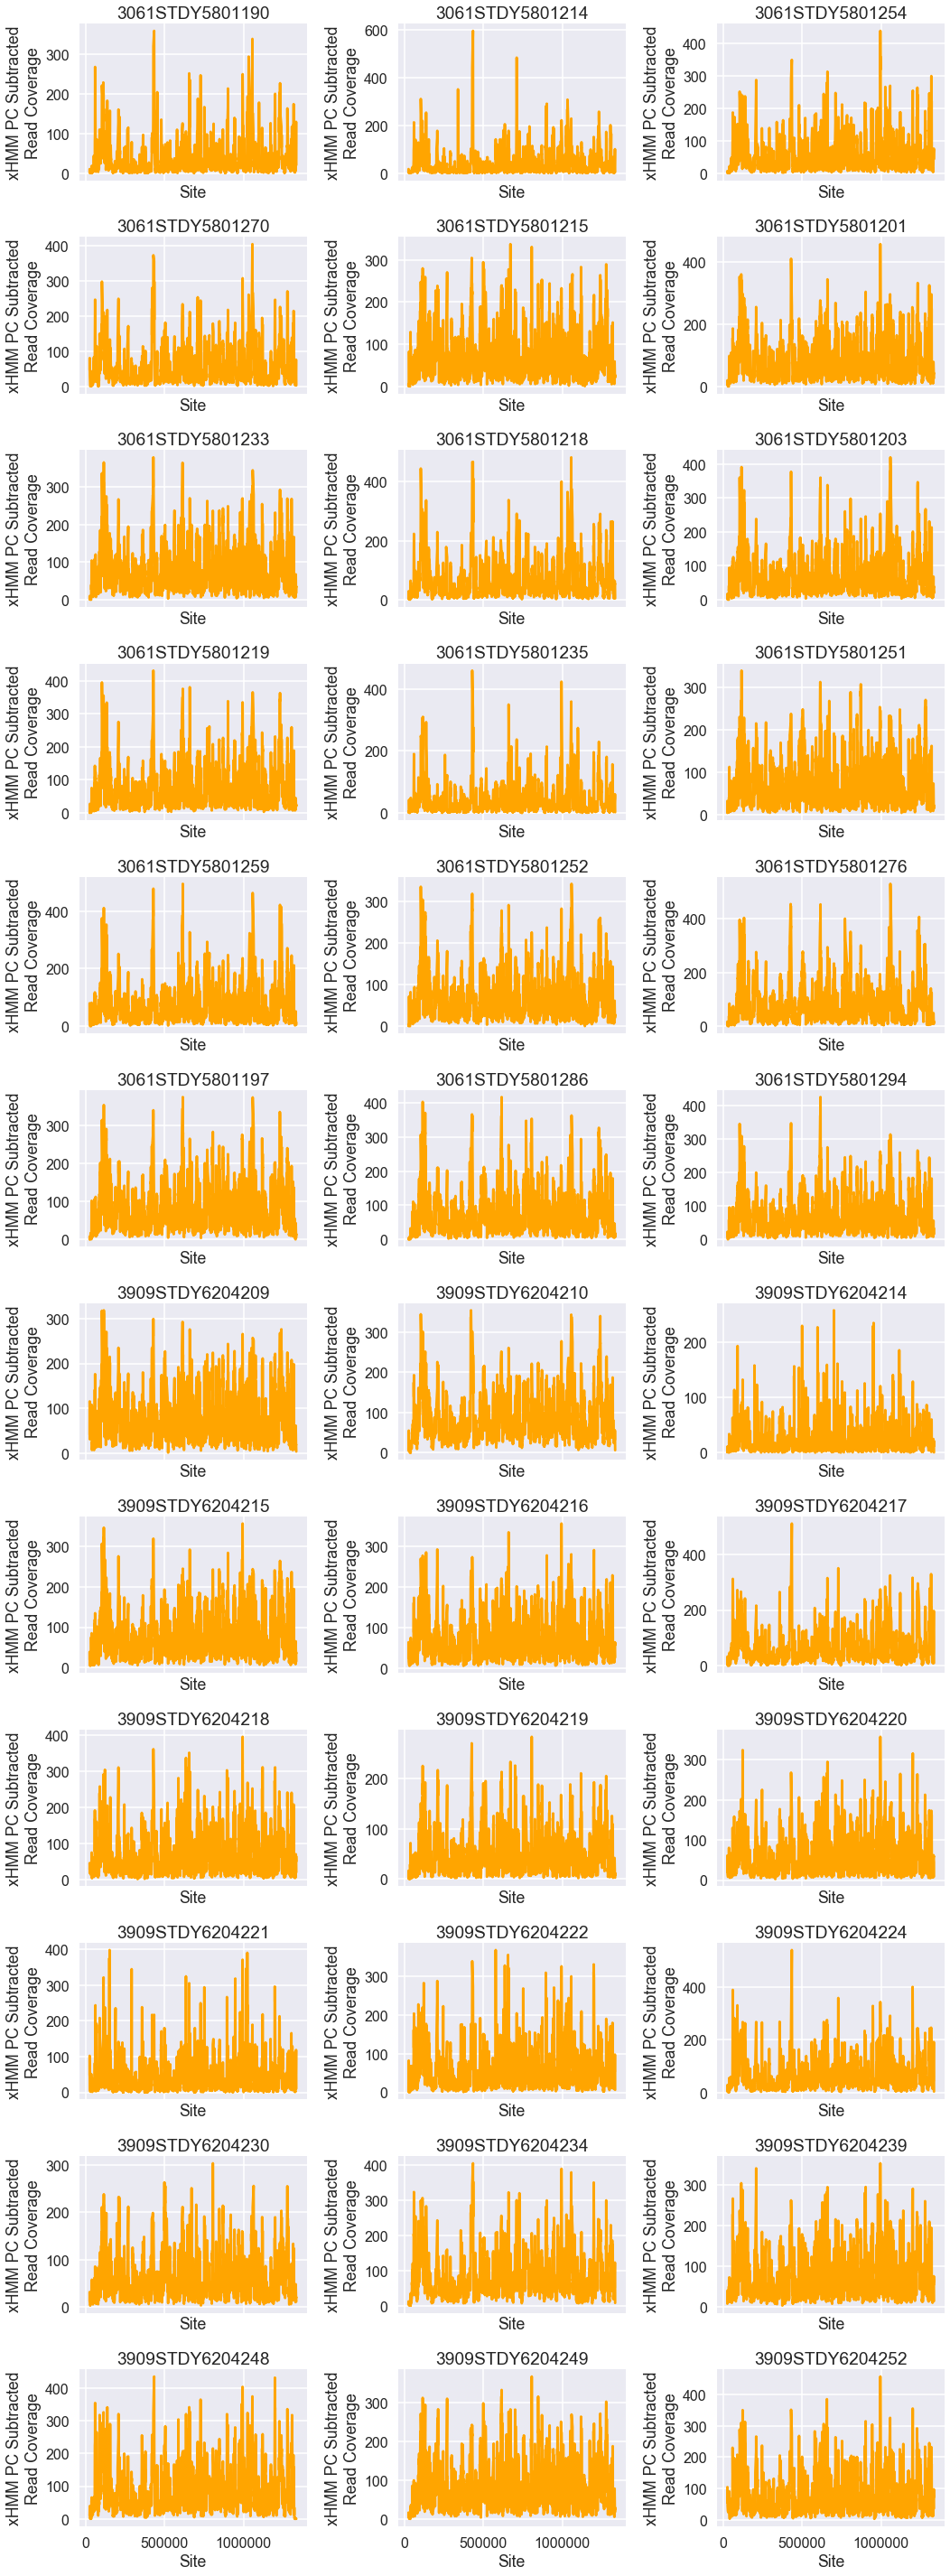

In [21]:
plotter(total_cols=3, samples=samples, sample_col="seqscape_name_wgs_Hiseq2000", 
        df=xhmm_rd, y_label="xHMM PC Subtracted\nRead Coverage", x_label="Site", 
        x_col="window", y_col="norm_cov", sharey=False)

## Concordance Between Gausssian HMM and xHMM Copy Number Calls

% of calls that are the same between Gaussian HMM and xHMM

In [22]:
100 * bothmap[bothmap["copy_number"] == bothmap["copy_number.xhmm"]].shape[0]/bothmap.shape[0]

75.20788498516471

% of xHMM copy number calls (>=2X) also called by Gaussian HMM

In [23]:
100 * bothmap[(bothmap["copy_number"] == bothmap["copy_number.xhmm"]) &
             (bothmap["copy_number.xhmm"] > 1)].shape[0]/ bothmap[
                 (bothmap["copy_number.xhmm"] > 1)].shape[0]

33.87096774193548

% of deletions xHMM deletions also called by Gaussian HMM

In [24]:
100 * bothmap[(bothmap["copy_number"] == bothmap["copy_number.xhmm"]) &
             (bothmap["copy_number.xhmm"] == 0)].shape[0]/ bothmap[
                 (bothmap["copy_number.xhmm"] == 0)].shape[0]

3.625170998632011

% of xHMM single copy number calls (1X) also called by Gaussian HMM

In [25]:
100 * bothmap[(bothmap["copy_number"] == bothmap["copy_number.xhmm"]) &
             (bothmap["copy_number.xhmm"] == 1)].shape[0]/ bothmap[
                 (bothmap["copy_number.xhmm"] == 1)].shape[0]

76.45744292713437

Pearson Correlation Between Gaussian HMM and xHMM

In [26]:
bothmap[["copy_number", "copy_number.xhmm"]].corr(method='spearman', min_periods=1)

,copy_number,copy_number.xhmm
copy_number,1.000000,0.084112
copy_number.xhmm,0.084112,1.000000
